In [1]:
import pandas as pd
import os
import seaborn as sns
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy
import math


In [2]:
ACC_CEIL = 88.88
MAX_MB = 350000
RSM_BASE = base='/Users/jeremygordon/Google Drive/Professional/Work Places/Internships Fellowships/2019 Numenta/rsm_highlights/'

def get_event_filename(dir, base='/Users/jeremygordon/Google Drive/Professional/Work Places/Internships Fellowships/2019 Numenta/rsm_highlights/SMNIST/'):
    for path in os.listdir(base + dir):   
        if 'events' in path:    
            return base + dir + '/' + path
    print("No event for %s" % dir)

def downsample_arr(arr, factor=2):
    pad_size = math.ceil(float(arr.size)/factor)*factor - arr.size
    b_padded = np.append(arr, np.zeros(pad_size)*np.NaN)
    return scipy.nanmean(b_padded.reshape(-1, factor), axis=1)
    
def get_curve(filename, downsample=0):
    xaxis = []
    accs = []
    rsm = "RSMTune" in filename
    event_count = 0
    for event in tf.compat.v1.train.summary_iterator(filename):
        for value in event.summary.value:
            if 'acc' in value.tag:
                acc = value.simple_value
                accs.append(acc)
                xaxis.append(event.step)
        event_count += 1
    xaxis = np.array(xaxis)
    accs = np.array(accs)
    if rsm:
        xaxis *= 100  # As per batches_in_epoch
    if downsample:
        accs = downsample_arr(accs, factor=downsample)
        xaxis = downsample_arr(xaxis, factor=downsample)        
    return xaxis, accs

## PTB runs

In [ ]:
def get_result_curve(filename):
    xaxis = []
    val_interp_ppl = []
    val_loss = []
    for event in tf.compat.v1.train.summary_iterator(filename):
        if not xaxis or xaxis[-1] != event.step:
            xaxis.append(event.step)
        for value in event.summary.value:
            if 'val_interp_ppl' in value.tag:
                ppl = value.simple_value
                val_interp_ppl.append(ppl)
            elif 'val_loss' in value.tag:
                loss = value.simple_value
                val_loss.append(loss)
    return xaxis, val_interp_ppl, val_loss

for dirname in [
    "Flat_PTB_Abl_Inh",
    "Flat_PTB_Abl_NoEmbed",
    "Flat_PTB_Abl_NonFlat",
    "Flat_PTB_Abl_StaticDecay"
]:
    filename = get_event_filename(dirname, base='./PTB/Ablation/')
    xaxis, val_interp_ppl, val_loss = get_result_curve(filename)
    print(dirname, 'best ppl', min(val_interp_ppl))

## Mean/SD SMNIST charts

bRSM (partitioned) SD 0.062 Best mean LSTM 88.841 best max 88.941 mean % of ceil 1.000
bRSM SD 0.308 Best mean LSTM 86.432 best max 86.767 mean % of ceil 0.972
LSTM ($mbs=cont$ $k_2=30$) SD 9.153 Best mean LSTM 80.002 best max 81.389 mean % of ceil 0.900
mbs=cont SD 9.153 Best mean LSTM 80.002 best max 81.389 mean % of ceil 0.900
mbs=100 SD 18.191 Best mean LSTM 73.435 best max 82.680 mean % of ceil 0.826
mbs=50 SD 17.391 Best mean LSTM 72.831 best max 82.006 mean % of ceil 0.819
mbs=30 SD 6.462 Best mean LSTM 77.330 best max 79.099 mean % of ceil 0.870
$k_2$=20 SD 5.559 Best mean LSTM 77.511 best max 85.678 mean % of ceil 0.872
$k_2$=30 SD 18.191 Best mean LSTM 73.435 best max 82.680 mean % of ceil 0.826
$k_2$=50 SD 4.470 Best mean LSTM 47.593 best max 51.755 mean % of ceil 0.535


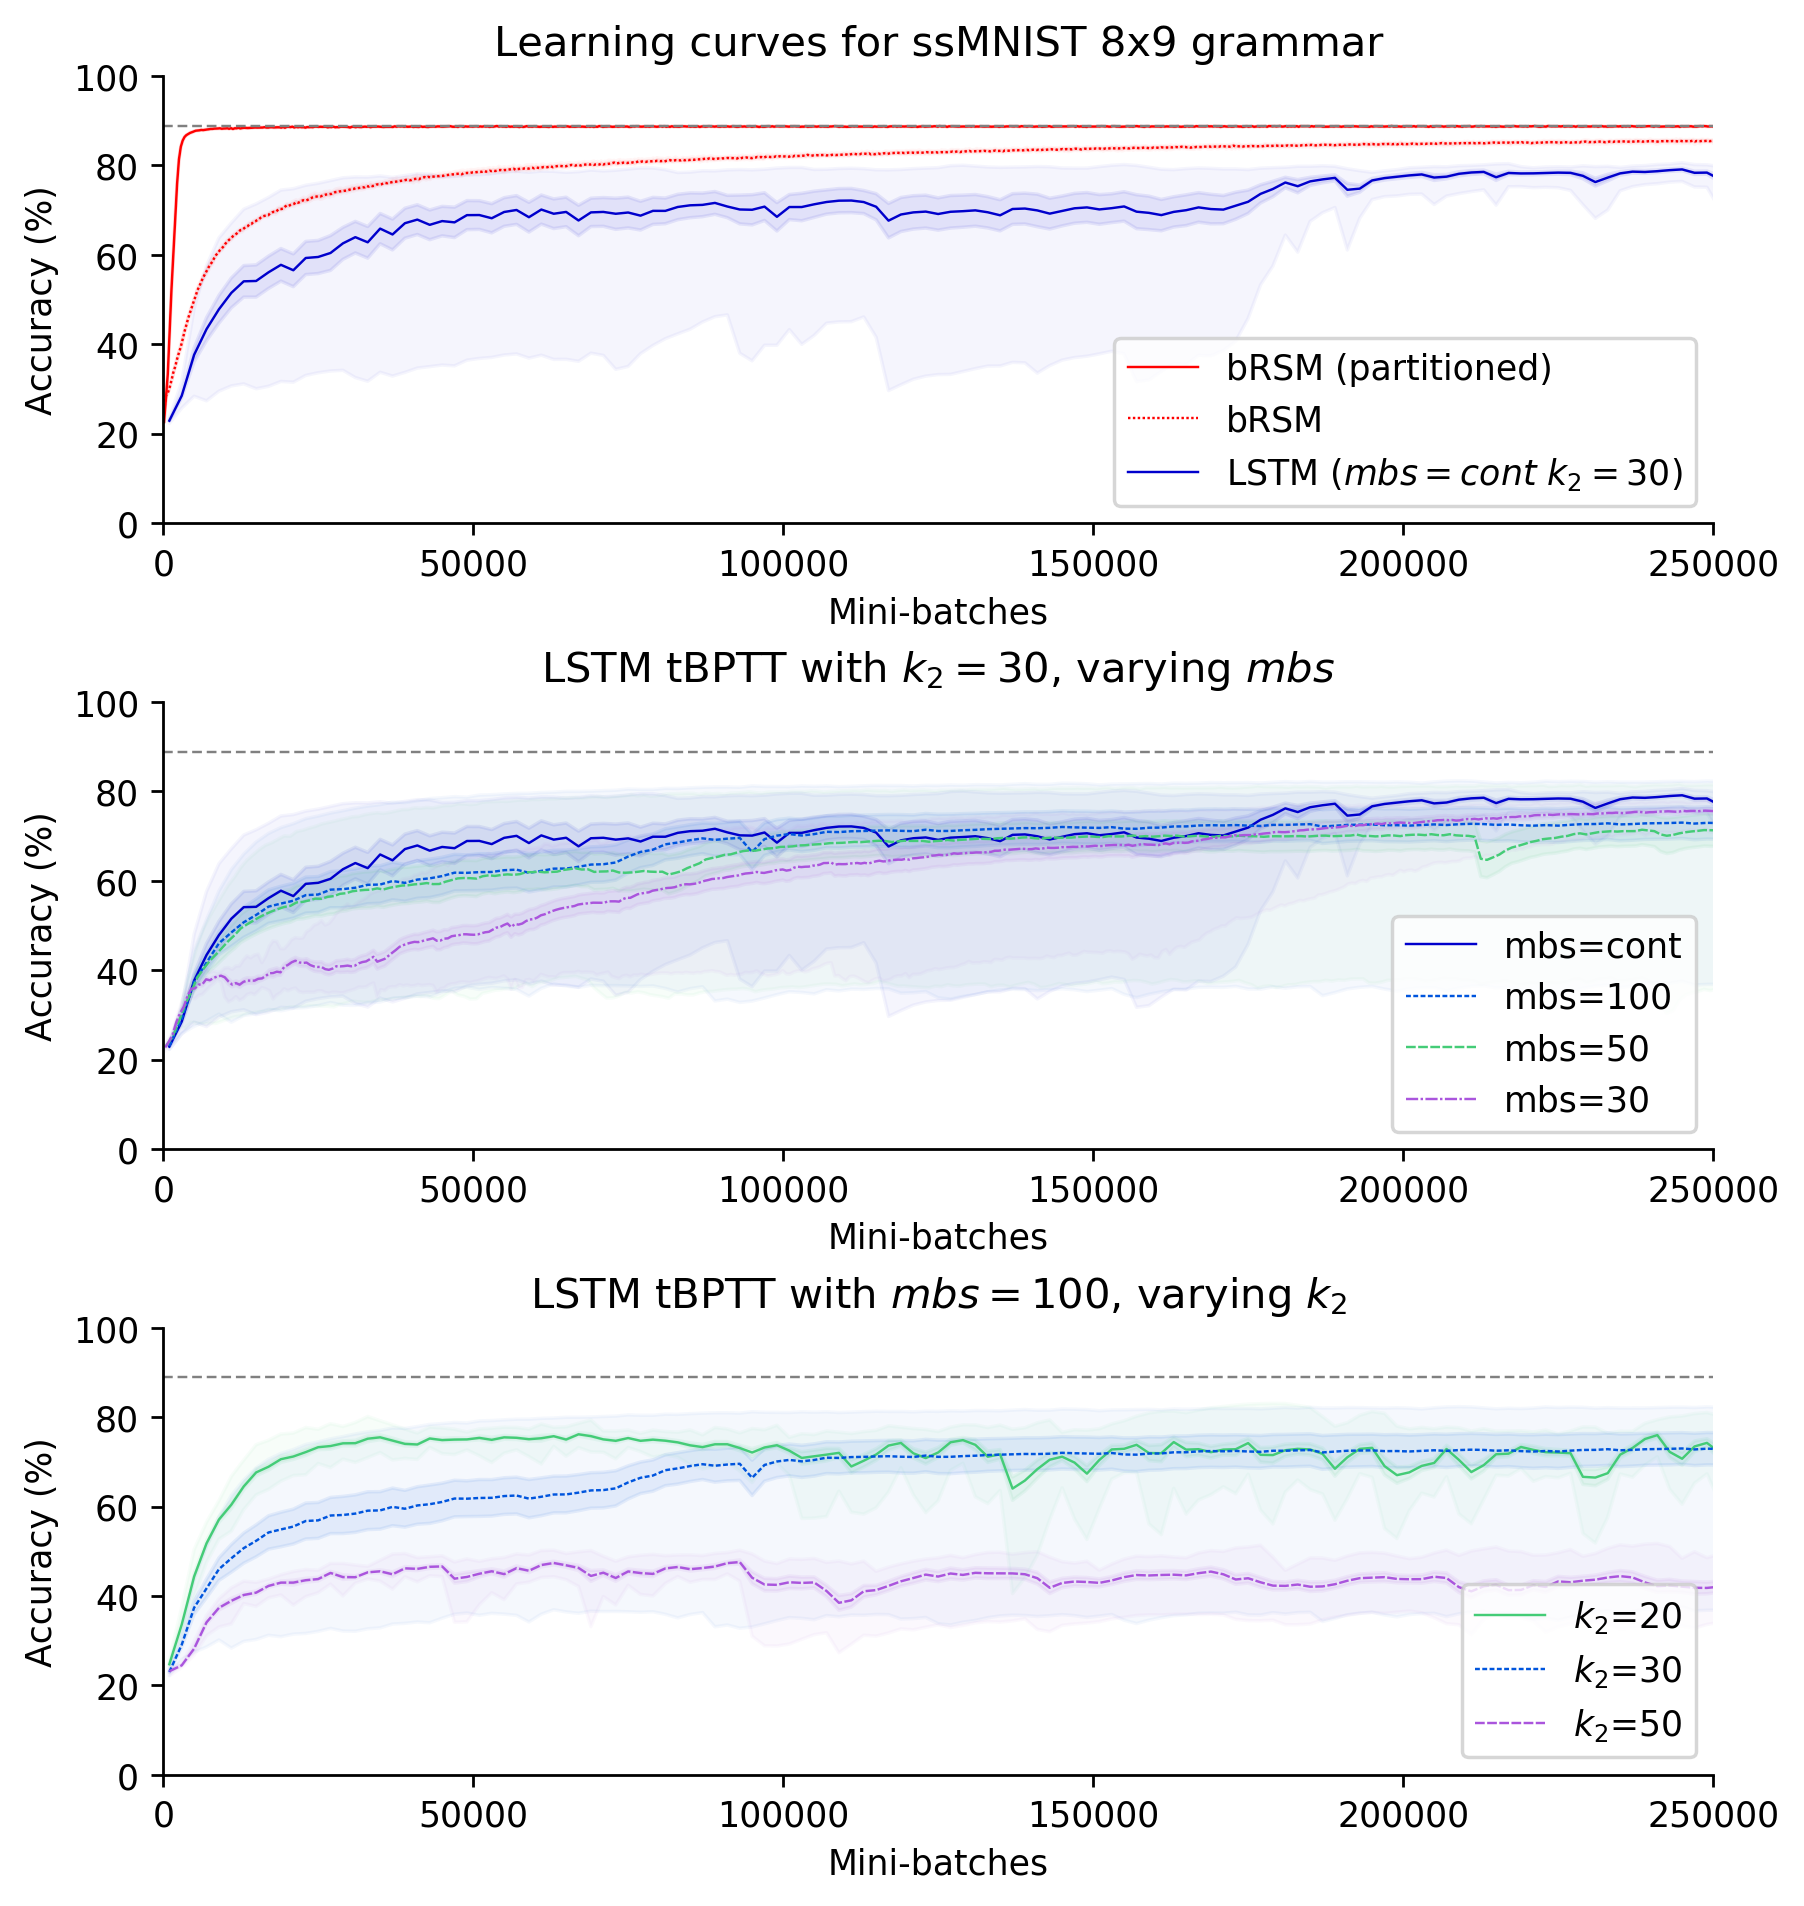

In [15]:
def mean_sd_series_in_folder(folder, key='train_acc', rsm=False, downsample=None):
    if downsample is None:
        downsample=3 if rsm else 20
    series = []
    xaxis = None
    count = 0
    
    for path in os.listdir(folder): 
        if os.path.isdir(folder + '/' + path):
            filename = get_event_filename(path, base=folder + '/')
            xaxis = []
            vals = []
            for event in tf.compat.v1.train.summary_iterator(filename):
                if not xaxis or xaxis[-1] != event.step:
                    xaxis.append(event.step)
                for value in event.summary.value:
                    if key in value.tag:
                        val = value.simple_value
                        vals.append(val)
            if series and len(vals) > len(series[-1]):
                vals = vals[:len(series[-1])]
            series.append(vals)
            count += 1
    series = np.stack(series)
    xaxis = np.array(xaxis)
    mean = np.mean(series, axis=0)
    mins = np.min(series, axis=0)
    maxs = np.max(series, axis=0)
    se = np.std(series, axis=0) / count
    if rsm:
        xaxis *= 100  # As per batches_in_epoch
    if downsample:
        mean = downsample_arr(mean, factor=downsample)
        se = downsample_arr(se, factor=downsample)
        mins = downsample_arr(mins, factor=downsample)
        maxs = downsample_arr(maxs, factor=downsample)
        xaxis = downsample_arr(xaxis, factor=downsample)
    sd = (se * count).mean()
    return xaxis[:len(mean)], mean, se, sd, count, mins, maxs

def plot_mean_sd(ax, xaxis, vals, ses, sd, label, color, mins, maxs, dashes=(None, None), alpha=0.08, with_range=False):
    ax.plot(xaxis, vals, label=label, c=color, dashes=dashes, linewidth=LW)
    ax.fill_between(xaxis, vals-ses, vals+ses, alpha=alpha, color=color)
    if with_range:
        ax.fill_between(xaxis, mins, maxs, alpha=alpha/2, color=color)
    print(label, "SD %.3f" % sd, "Best mean LSTM %.3f" % vals.max(), "best max %.3f" % maxs.max(), "mean %% of ceil %.3f" % (vals.max() / ACC_CEIL))
        
LW = 0.7
fig, axs = plt.subplots(3, 1, dpi=250, figsize=(8, 9))
plt.subplots_adjust(hspace=0.4)

### Showing bRSM and best LSTM in plt 1

xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + "SMNIST/Best RSM/pbRSM", key='acc', rsm=True)
plot_mean_sd(axs[0], xaxis, mean, se, sd, "bRSM (partitioned)", 'red', mins, maxs, with_range=True)

xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + "SMNIST/Best RSM/bRSM", key='acc', rsm=True)
plot_mean_sd(axs[0], xaxis, mean, se, sd, "bRSM", 'red', mins, maxs, dashes=(1, 1), with_range=True)
             
# BEST_LSTM = "mbs 100 k2 30"
# label = "$mbs=100$ $k_2=30$"
BEST_LSTM = "mbs cont k2 30"
label = "$mbs=cont$ $k_2=30$"
color_dash = ("#0000CC", (None, None))
xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + 'SMNIST/LSTM Variance/nhid450/' + BEST_LSTM)
plot_mean_sd(axs[0], xaxis, mean, se, sd, "LSTM (%s)" % (label), color_dash[0], mins, maxs, color_dash[1], with_range=True)

axs[0].set_title("Learning curves for ssMNIST 8x9 grammar")

### Showing variation in LSTM config in plt 2

for config, color, dashes in [
    ("mbs cont k2 30", "#0000CC", None),
    #("mbs 150 k2 30", "#0055DD", (1, 1)),
    ("mbs 100 k2 30", "#0055DD", (2, 1)),
    ("mbs 50 k2 30", "#44CC77", (4, 1)),
    ("mbs 30 k2 30", "#AA55DD", (5, 1, 1, 1)),
    ]:
    xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + 'SMNIST/LSTM Variance/nhid450/' + config)
    if xaxis is not None:
        if dashes is None:
            dashes = (None, None)
        label=config.replace(" k2 30", "").replace(" ", "=")
        plot_mean_sd(axs[1], xaxis, mean, se, sd, label, color, mins, maxs, dashes, with_range=True)
        
axs[1].set_title("LSTM tBPTT with $k_2=30$, varying $mbs$")

for config, color, dashes in [
    ("mbs 100 k2 20", "#44CC77", None),
    ("mbs 100 k2 30", "#0055DD", (2, 1)),
    ("mbs 100 k2 50", "#AA55DD", (4, 1)),
    ]:
    xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + 'SMNIST/LSTM Variance/nhid450/' + config)
    if xaxis is not None:
        if dashes is None:
            dashes = (None, None)
        label=config.replace("mbs 100 ", "").replace(" ", "=").replace("k2", "$k_2$")
        plot_mean_sd(axs[2], xaxis, mean, se, sd, label, color, mins, maxs, dashes, with_range=True)

axs[2].set_title("LSTM tBPTT with $mbs=100$, varying $k_2$")

for ax in axs:
    ax.set_xlabel("Mini-batches")
    ax.legend(loc='lower right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim((0, 100))
    ax.set_xlim((0, MAX_MB))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([0, MAX_MB], [ACC_CEIL, ACC_CEIL], c='gray', dashes=[4, 2], linewidth=LW)
    

plt.savefig('./Charts/ssmnist_mean_sd_acc.png')
plt.show()


### Fixed ssMNIST

bRSM SD 0.544 Best mean LSTM 86.262 best max 87.188 mean % of ceil 0.971
LSTM mbs=cont $k_2=30$ SD 4.655 Best mean LSTM 88.697 best max 89.120 mean % of ceil 0.998


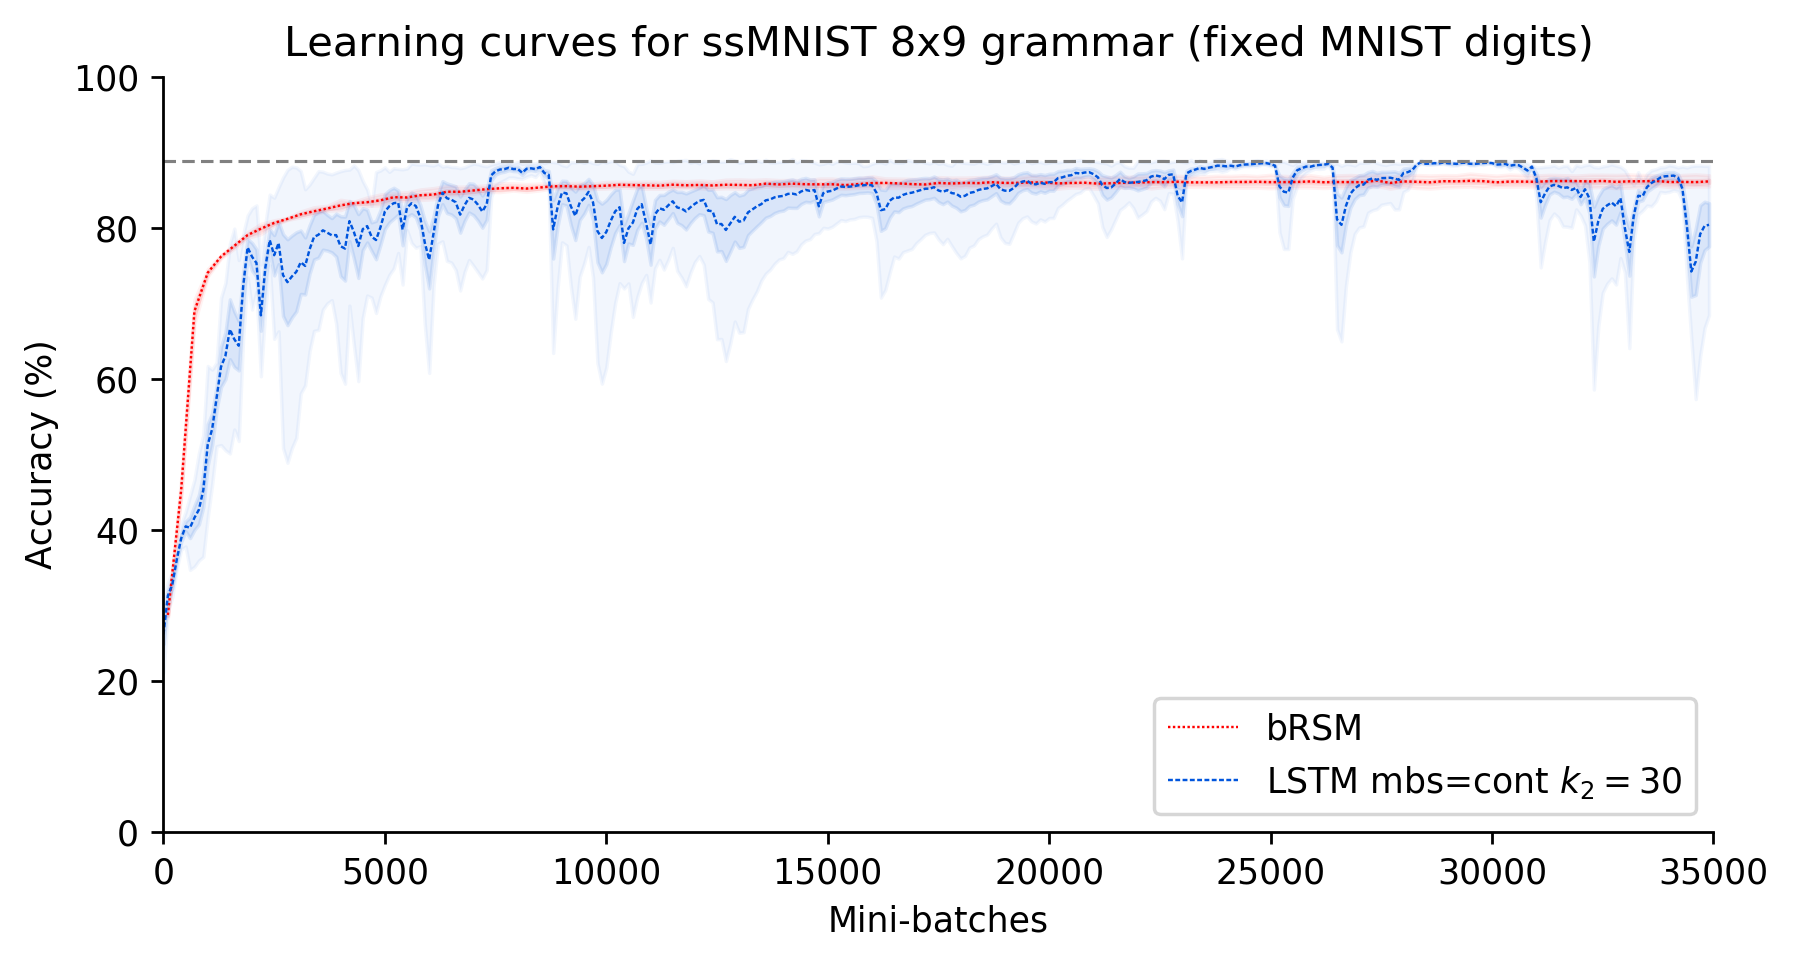

In [64]:

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(8, 4))

xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + 'SMNIST/Fixed SMNIST/bRSM', key='acc', rsm=True)
plot_mean_sd(ax, xaxis, mean, se, sd, "bRSM", 'red', mins, maxs, (1, 1), with_range=True, alpha=0.1)

xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + 'SMNIST/Fixed SMNIST/LSTM cont', downsample=0)
plot_mean_sd(ax, xaxis, mean, se, sd, "LSTM mbs=cont $k_2=30$", '#0055DD', mins, maxs, (2, 1), with_range=True, alpha=0.1)

ax.set_title("Learning curves for ssMNIST 8x9 grammar (fixed MNIST digits)")
ax.set_xlabel("Mini-batches")
ax.legend(loc='lower right')
ax.set_ylabel("Accuracy (%)")
ax.set_ylim((0, 100))
ax.set_xlim((0, 35000))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(ax.get_xlim(), [ACC_CEIL, ACC_CEIL], c='gray', dashes=[4, 2], linewidth=0.9)

plt.savefig('./Charts/ssmnist_fixed_acc.png')
plt.show()

## Cosyne 20

bRSM SD 0.308 Best mean LSTM 86.432 best max 86.767 mean % of ceil 0.972
LSTM SD 9.153 Best mean LSTM 80.002 best max 81.389 mean % of ceil 0.900


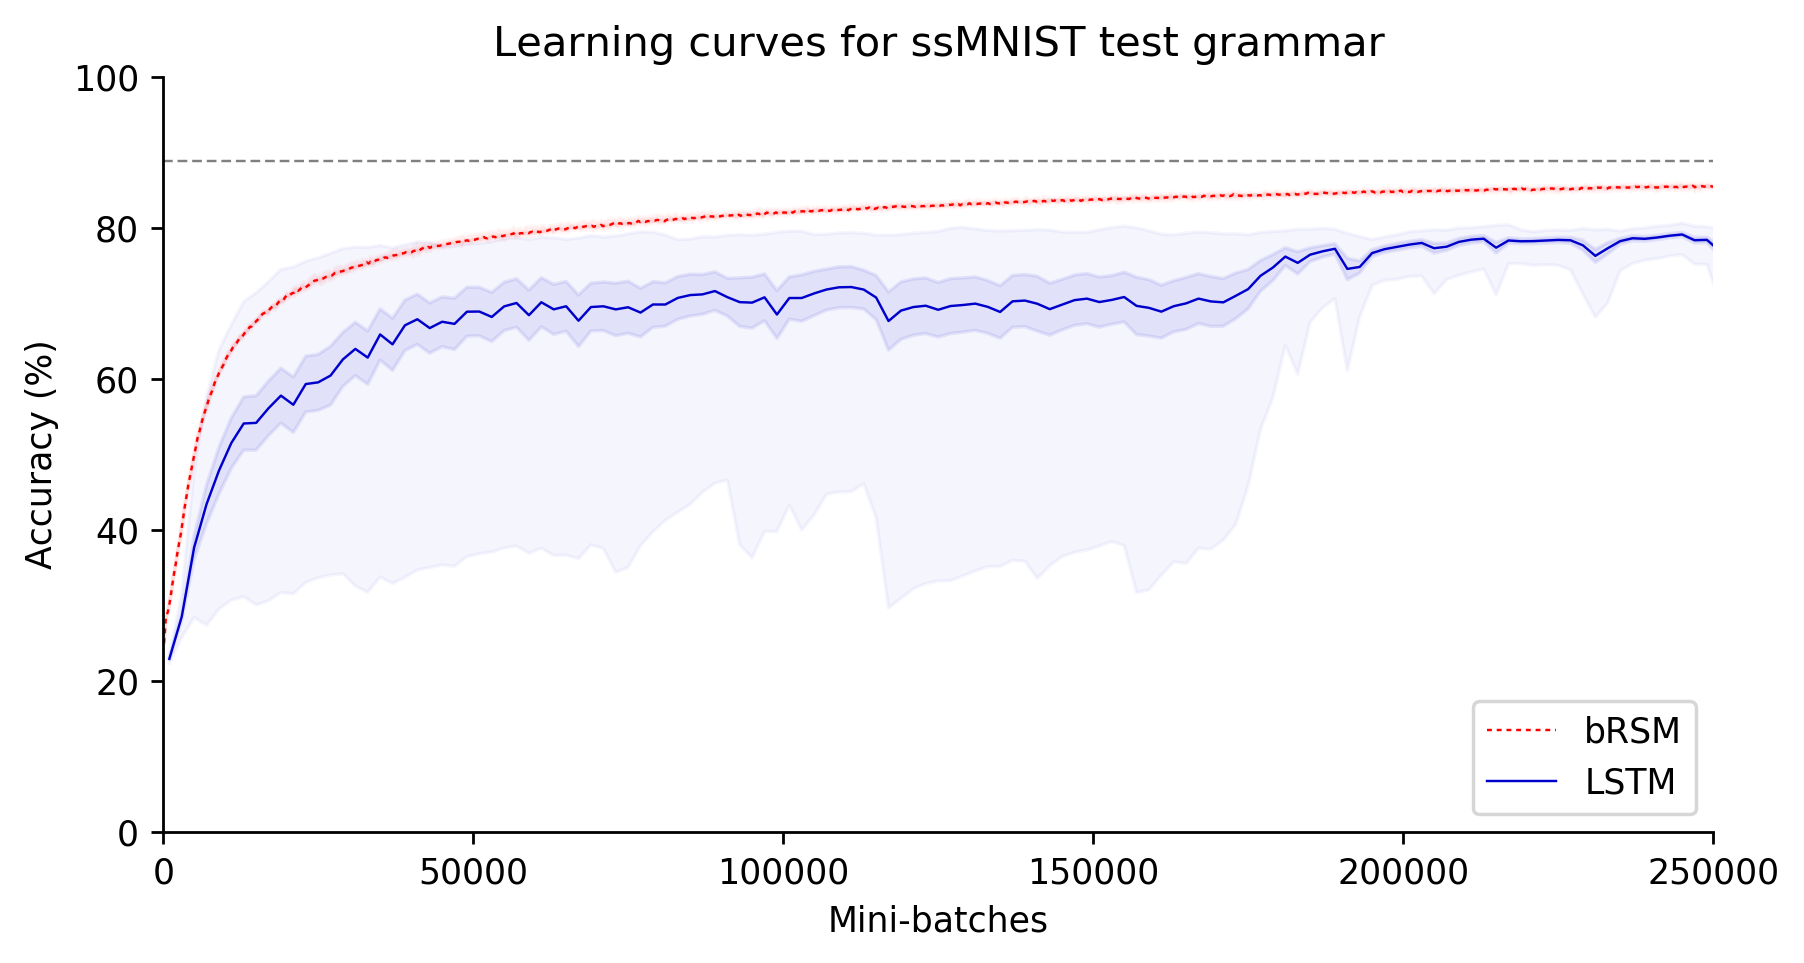

In [17]:
  
LW = 0.7
MAX_MB =250000
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(8, 4))
plt.subplots_adjust(hspace=0.4)

### Showing bRSM and best LSTM in plt 1

# xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + "SMNIST/Best RSM/pbRSM", key='acc', rsm=True)
# plot_mean_sd(ax, xaxis, mean, se, sd, "bRSM (partitioned)", 'red', mins, maxs, with_range=True)

xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + "SMNIST/Best RSM/bRSM", key='acc', rsm=True)
plot_mean_sd(ax, xaxis, mean, se, sd, "bRSM", 'red', mins, maxs, dashes=(2, 2), with_range=True)
             
# BEST_LSTM = "mbs 100 k2 30"
# label = "$mbs=100$ $k_2=30$"
BEST_LSTM = "mbs cont k2 30"
label = "$mbs=cont$ $k_2=30$"
color_dash = ("#0000CC", (None, None))
xaxis, mean, se, sd, count, mins, maxs = mean_sd_series_in_folder(RSM_BASE + 'SMNIST/LSTM Variance/nhid450/' + BEST_LSTM)
plot_mean_sd(ax, xaxis, mean, se, sd, "LSTM", color_dash[0], mins, maxs, color_dash[1], with_range=True)

ax.set_title("Learning curves for ssMNIST test grammar")

for ax in [ax]:
    ax.set_xlabel("Mini-batches")
    ax.legend(loc='lower right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim((0, 100))
    ax.set_xlim((0, MAX_MB))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([0, MAX_MB], [ACC_CEIL, ACC_CEIL], c='gray', dashes=[4, 2], linewidth=LW)
    

plt.savefig('./Charts/ssmnist_mean_sd_acc_cosyne.png')
plt.show()
